In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import joblib
from scipy.sparse import load_npz

## Load processed dataset

In [2]:
# Load train processed data
X_train = load_npz('../data/processed/X_train.npz')
y_train = np.load('../data/processed/y_train.npy')

# Load test processed data
X_test = load_npz('../data/processed/X_test.npz')
y_test = np.load('../data/processed/y_test.npy')

## Train the model with GridSearchCV

In [3]:
parameters = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
model = MultinomialNB()
clf = GridSearchCV(model, parameters,cv=10, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]})

In [4]:
print(clf.best_params_)
print(clf.best_score_)

{'alpha': 0.1}
0.9907061057424938


## Test and evaluation

In [5]:
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9922489163176842
Test Accuracy: 0.985178970917226


In [6]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)       # Calculate the accuracy
report = classification_report(y_test, y_pred)  # Get the precision, recall, f1-score

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.86      0.83      0.84       173

    accuracy                           0.99      3576
   macro avg       0.93      0.91      0.92      3576
weighted avg       0.98      0.99      0.99      3576



In [8]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(conf_matrix)

[[3380   23]
 [  30  143]]


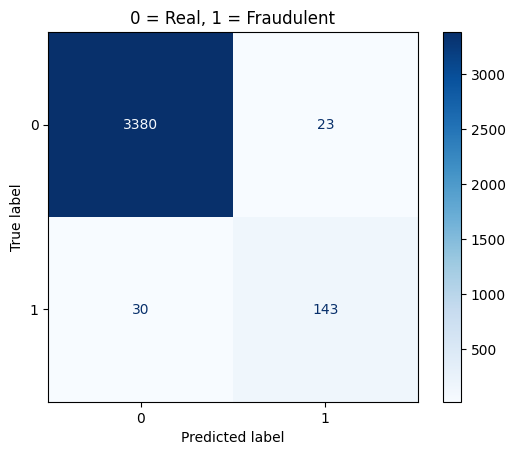

In [9]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("0 = Real, 1 = Fraudulent")
plt.show()

## Save the model

In [10]:
best_model = clf.best_estimator_
joblib.dump(best_model, '../models/modelMNB_v2.pkl')


['../models/modelMNB_v2.pkl']